In [1]:
import torch
# import facenet_pytorch
# import yaml
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
import numpy as np
from PIL import Image, ImageDraw
from IPython import display
import matplotlib.pyplot as plt
from torchvision import transforms

import torch
from torch import nn
from torchvision.models import resnet50
from facenet_pytorch import MTCNN, InceptionResnetV1

import imgaug.augmenters as iaa

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

/home/ivan/DELETE_AFTER_HACK/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Эксперементы модели

датасет


In [3]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.PILToTensor(),
])

In [4]:
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split

class CelebAspoofDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.filepaths = []
        self.labels = []

        for dirpath, dirnames, filenames in os.walk(self.root):
            for filename in filenames:
                filepath = os.path.join(dirpath, filename)
                self.filepaths.append(filepath)
                
                if '0live' in dirpath:
                    self.labels.append(0)
                else:
                    self.labels.append(1)

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        face = read_image(img_path)
        
        label = self.labels[idx]   
        
        if self.transform:
            face = self.transform(face)
            
        return (face, label)


In [5]:
path_local = 'data'
data = CelebAspoofDataset(path_local, transform=transform)

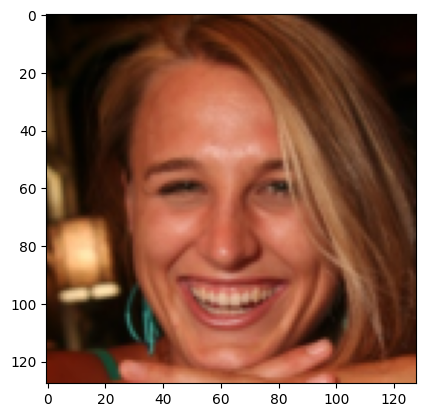

In [6]:
tmp = train[0][0].permute(1, 2, 0)
plt.imshow(tmp)
plt.show()


In [6]:
batch_size = 64
epochs = 500

In [7]:
train_size = int(0.8 * len(data))  # 70% данных для обучения
val_size = int(0.1 * len(data))  # 15% данных для валидации
test_size = len(data) - train_size - val_size  # 15% данных для тестирования
train_dataset, val_dataset, test_dataset = random_split(data, [train_size, val_size, test_size])

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

доп тест инструментов

In [9]:
train[0][0].shape

torch.Size([3, 128, 128])

In [10]:
train[0][0]

tensor([[[  2,   2,   2,  ...,   8,   8,   8],
         [  2,   3,   3,  ...,   9,   9,   8],
         [  2,   3,   3,  ...,   9,   8,   8],
         ...,
         [111, 110, 109,  ..., 199, 196, 196],
         [110, 109, 108,  ..., 201, 201, 196],
         [108, 108, 106,  ..., 204, 203, 205]],

        [[  2,   2,   3,  ...,   3,   3,   3],
         [  2,   3,   3,  ...,   4,   4,   3],
         [  2,   3,   3,  ...,   3,   3,   3],
         ...,
         [ 26,  24,  25,  ..., 119, 117, 116],
         [ 26,  26,  25,  ..., 123, 123, 118],
         [ 26,  25,  25,  ..., 126, 125, 127]],

        [[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   1,   1,   0],
         [  0,   1,   1,  ...,   1,   0,   0],
         ...,
         [  6,   7,   7,  ...,  74,  71,  71],
         [  6,   8,   7,  ...,  77,  77,  72],
         [  6,   7,   6,  ...,  78,  78,  79]]], dtype=torch.uint8)

In [74]:
mtcnn = MTCNN(post_process=False).eval().to('cpu')
detected_faces = mtcnn(train[0][0].permute(1, 2, 0))

data/0live/00001.jpg


In [75]:
detected_faces

tensor([[[ 78.,  80.,  82.,  ..., 109., 113., 116.],
         [ 80.,  80.,  83.,  ...,  98., 105., 103.],
         [ 82.,  80.,  82.,  ...,  84.,  94.,  95.],
         ...,
         [206., 214., 223.,  ..., 155., 151., 149.],
         [205., 213., 225.,  ..., 151., 145., 144.],
         [201., 209., 223.,  ..., 159., 154., 151.]],

        [[ 40.,  40.,  39.,  ...,  68.,  70.,  73.],
         [ 41.,  40.,  39.,  ...,  57.,  64.,  62.],
         [ 42.,  39.,  39.,  ...,  43.,  54.,  55.],
         ...,
         [113., 120., 128.,  ...,  70.,  66.,  65.],
         [120., 126., 137.,  ...,  63.,  57.,  57.],
         [124., 129., 139.,  ...,  69.,  64.,  62.]],

        [[ 18.,  18.,  16.,  ...,  45.,  46.,  49.],
         [ 17.,  16.,  16.,  ...,  36.,  42.,  39.],
         [ 17.,  15.,  15.,  ...,  23.,  33.,  34.],
         ...,
         [ 93., 100., 109.,  ...,  39.,  37.,  35.],
         [ 98., 104., 114.,  ...,  31.,  27.,  27.],
         [ 98., 103., 113.,  ...,  36.,  32.,  30.]]]

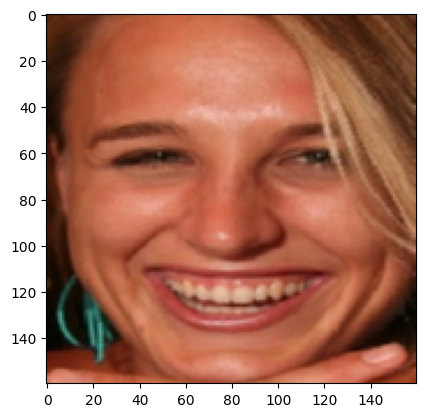

In [77]:
plt.imshow(detected_faces.permute(1, 2, 0).int())
plt.show()


In [82]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()
detected_faces = resnet(detected_faces.unsqueeze(0))

In [84]:
detected_faces.shape

torch.Size([1, 512])

MIDaS

In [8]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

In [86]:
# model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /home/ivan/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /home/ivan/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


In [87]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

MidasNet_small(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2dSameExport(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU6(inplace=True)
          (se): Identity()
          (conv_pw): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
        )
      )
      (4): Sequential(
        (0): InvertedResidual(
          (conv_pw): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(144,

In [96]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /home/ivan/.cache/torch/hub/intel-isl_MiDaS_master


In [97]:
input_batch = transform(train[0][0].permute(1, 2, 0).numpy()).to(device)

data/0live/00001.jpg


In [98]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

data/0live/00001.jpg


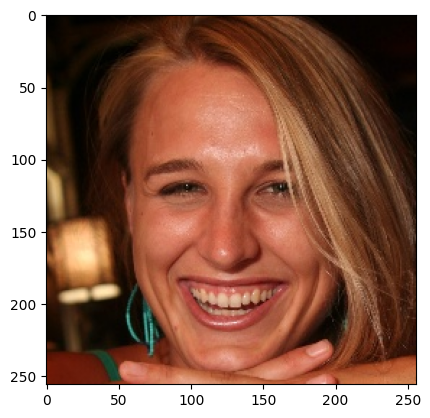

In [99]:
plt.imshow(train[0][0].permute(1, 2, 0).numpy())

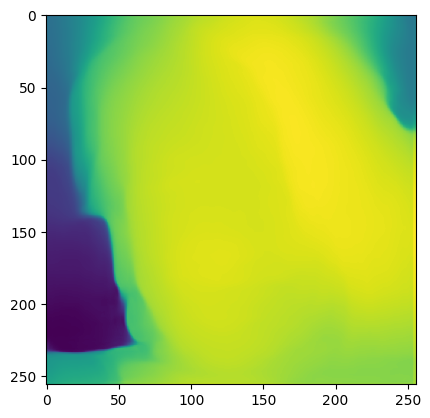

In [100]:
plt.imshow(output)

Сетки

добавить fc еще на выходе

In [9]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dense = nn.Linear(128*8*8, 512, bias=False)
        self.bn3 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(512+512, 2)

    def forward(self, x, mtcnn, resnet):
        x = x.to(device)
        x1 = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x1 = self.pool2(F.relu(self.bn2(self.conv2(x1))))
        x1 = x1.view(x.size(0), -1)
        x1 = self.dropout(self.bn3(self.dense(x1)))


        # Second input
        x2_list = torch.zeros((x.size(0), 512)).to(device)
        for i in range(x.size(0)):
            img = x[i].permute(1, 2, 0).cpu()  # Перемещение изображения на CPU
            detected_faces = mtcnn(img)
            if detected_faces is not None:
                detected_faces = detected_faces.unsqueeze(0).to(device) # add batch dimension
                resnet.eval()
                detected_faces = resnet(detected_faces)
            else:
                detected_faces = torch.zeros((1, 512)).to(device) # assuming the output of resnet is of shape (batch_size, 512)
            x2_list[i] = detected_faces

        x = torch.cat((x1, x2_list), dim=1)

        # Classification
        x = self.fc(x)

        return x


обучение MCNN

In [33]:
model = CustomModel()
model.to(device)


criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

mtcnn_model = MTCNN().eval().cpu()  # MTCNN на CPU
resnet_model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [34]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from sklearn.metrics import f1_score


# Функция обучения
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    for images, labels in tqdm(dataloader):
        images = images.to(device).float()
        labels = labels.to(device).long()
        optimizer.zero_grad()
        outputs = model(images, mtcnn_model, resnet_model)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()



# Функция валидации
def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device).float()
            labels = labels.to(device).long()
            outputs = model(images, mtcnn_model, resnet_model)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            # Сохраняем метки и прогнозы для вычисления F1-оценки
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    val_loss /= len(dataloader.dataset)
    val_accuracy = 100. * correct / len(dataloader.dataset)

    # Вычисляем F1-оценку
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    return val_loss, val_accuracy, f1

# Обучение и валидация модели
for epoch in range(1):  # 10 эпох для примера
    train(model, train_loader, criterion, optimizer, device)
    

100%|██████████| 724/724 [1:05:33<00:00,  5.43s/it]


NameError: name 'valid_loader' is not defined

In [35]:
torch.save(model.state_dict(), f'model_mtcnn.pth')

In [52]:
val_loss, val_accuracy, f1 = validate(model, val_loader, criterion, device)
print(f'Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, F1 Score: {f1}')

100%|██████████| 73/73 [04:33<00:00,  3.75s/it]

Val Loss: 0.000323706237422242, Val Accuracy: 99.26565874730022, F1 Score: 0.9926587096862103


In [14]:
del model
del mtcnn_model
del resnet_model

In [10]:
model = CustomModel()
model.load_state_dict(torch.load('model_mtcnn.pth', map_location=device))
model.to(device)

mtcnn_model = MTCNN().eval().cpu()  # MTCNN на CPU
resnet_model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from tqdm import tqdm

model.eval()

# предположим, что у вас есть модель model и test_loader
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device).long()
        outputs = model(images, mtcnn_model, resnet_model)
        _, predicted = torch.max(outputs.data, 1)

        # Сохраняем метки и прогнозы для вычисления F1-оценки
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())


# Расчет метрик
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


100%|██████████| 73/73 [03:57<00:00,  3.25s/it]

Accuracy: 0.9922279792746114
Precision: 0.9961240310077519
Recall: 0.9899845916795069
F1 Score: 0.9930448222565688


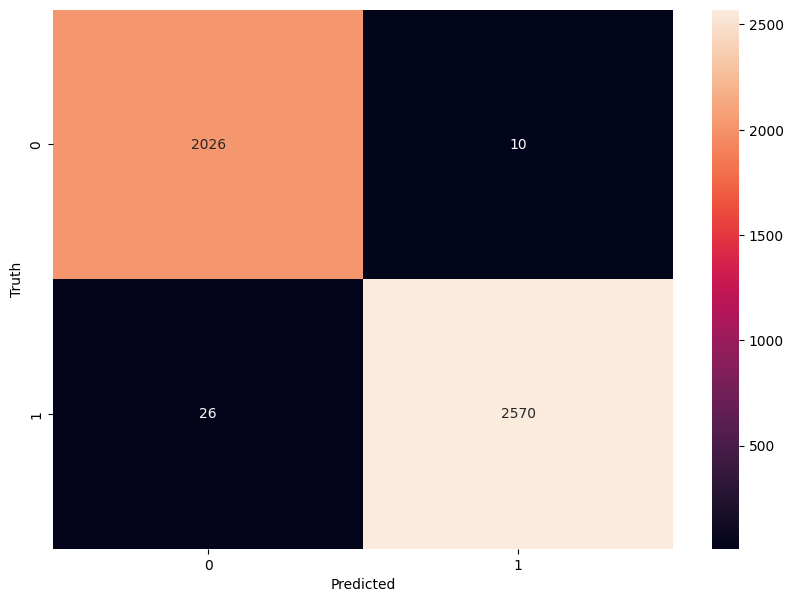

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Расчет confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Визуализация confusion matrix с использованием seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


inference

In [ ]:
del model
del mtcnn_model
del resnet_model

In [ ]:
model = CustomModel()
model.load_state_dict(torch.load('model_mtcnn.pth', map_location='cpu'))

mtcnn_model = MTCNN().eval().cpu()  # MTCNN на CPU
resnet_model = InceptionResnetV1(pretrained='vggface2').eval().to('cpu')

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from tqdm import tqdm

model.eval()


with torch.no_grad():
    images, labels = data[0]
    images = images.to('cpu').float().unsqueeze(0)
    start = time.time()
    outputs = model(images, mtcnn_model, resnet_model)
    end = time.time()

print(f'INFERENCE_TIME: {(end-start)}')



INFERENCE_TIME: 0.11696410179138184


Обучение свертки

In [32]:
class CustomModel2(nn.Module):
    def __init__(self):
        super(CustomModel2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dense = nn.Linear(128*8*8, 512, bias=False)
        self.bn3 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(512, 2)

    def forward(self, x):
        x = x

        # First input
        x1 = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x1 = self.pool2(F.relu(self.bn2(self.conv2(x1))))
        x1 = x1.view(x.size(0), -1)
        x1 = self.dropout(self.bn3(self.dense(x1)))
        x = self.fc(x1)

        return x

In [22]:
model = CustomModel2()
model.to(device)


criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [12]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from sklearn.metrics import f1_score


# Функция обучения
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    for images, labels in tqdm(dataloader):
        images = images.to(device).float()
        labels = labels.to(device).long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()



# Функция валидации
def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device).float()
            labels = labels.to(device).long()
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            # Сохраняем метки и прогнозы для вычисления F1-оценки
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    val_loss /= len(dataloader.dataset)
    val_accuracy = 100. * correct / len(dataloader.dataset)

    # Вычисляем F1-оценку
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    return val_loss, val_accuracy, f1


In [26]:

# Обучение и валидация модели
for epoch in range(1):  # 10 эпох для примера
    train(model, train_loader, criterion, optimizer, device)
    torch.save(model.state_dict(), f'model_conv.pth')
    val_loss, val_accuracy, f1 = validate(model, val_loader, criterion, device)
    print(f'Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, F1 Score: {f1}')

100%|██████████| 73/73 [00:13<00:00,  5.44it/s]

Val Loss: 0.00044913755339564306, Val Accuracy: 98.96328293736501, F1 Score: 0.9896191907104958


In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from tqdm import tqdm

model.eval()

# предположим, что у вас есть модель model и test_loader
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device).long()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Сохраняем метки и прогнозы для вычисления F1-оценки
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())


# Расчет метрик
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


100%|██████████| 73/73 [00:13<00:00,  5.23it/s]

Accuracy: 0.9885578583765112
Precision: 0.9840121811952798
Recall: 0.9957627118644068
F1 Score: 0.9898525751483821


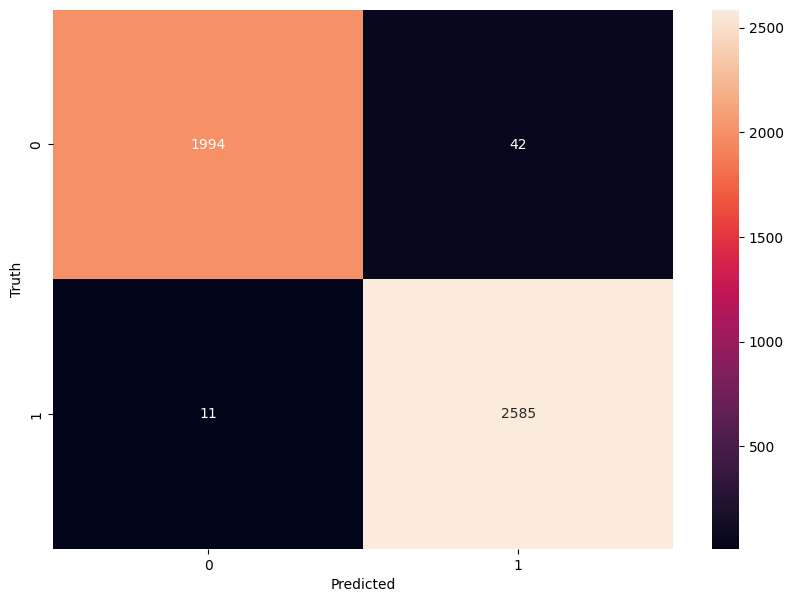

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Расчет confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Визуализация confusion matrix с использованием seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from tqdm import tqdm

model = CustomModel2()
model.load_state_dict(torch.load('model_conv.pth', map_location='cpu'))
model.eval()


with torch.no_grad():
    images, labels = data[0]
    images = images.to('cpu').float().unsqueeze(0)
    start = time.time()
    outputs = model(images)
    end = time.time()

print(f'INFERENCE_TIME: {(end-start)}')

INFERENCE_TIME: 0.06806659698486328


MObilaNEt

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms


# Загрузка модели без предварительного обучения
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(model.last_channel, 2)
model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
for epoch in range(2):  # 10 эпох для примера
    train(model, train_loader, criterion, optimizer, device)
    torch.save(model.state_dict(), f'model_mobileNet.pth')
    val_loss, val_accuracy, f1 = validate(model, val_loader, criterion, device)
    print(f'Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, F1 Score: {f1}')


/home/ivan/DELETE_AFTER_HACK/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ivan/DELETE_AFTER_HACK/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 73/73 [00:13<00:00,  5.22it/s]


Val Loss: 0.0006272690824962666, Val Accuracy: 98.59611231101512, F1 Score: 0.985975908630105


100%|██████████| 73/73 [00:12<00:00,  5.66it/s]

Val Loss: 0.0004155867395507168, Val Accuracy: 99.04967602591793, F1 Score: 0.9904892295055524


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from tqdm import tqdm

model.eval()

# предположим, что у вас есть модель model и test_loader
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device).long()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Сохраняем метки и прогнозы для вычисления F1-оценки
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())


# Расчет метрик
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


100%|██████████| 73/73 [00:14<00:00,  5.13it/s]

Accuracy: 0.9902849740932642
Precision: 0.9891141141141141
Recall: 0.993964541682384
F1 Score: 0.9915333960489182


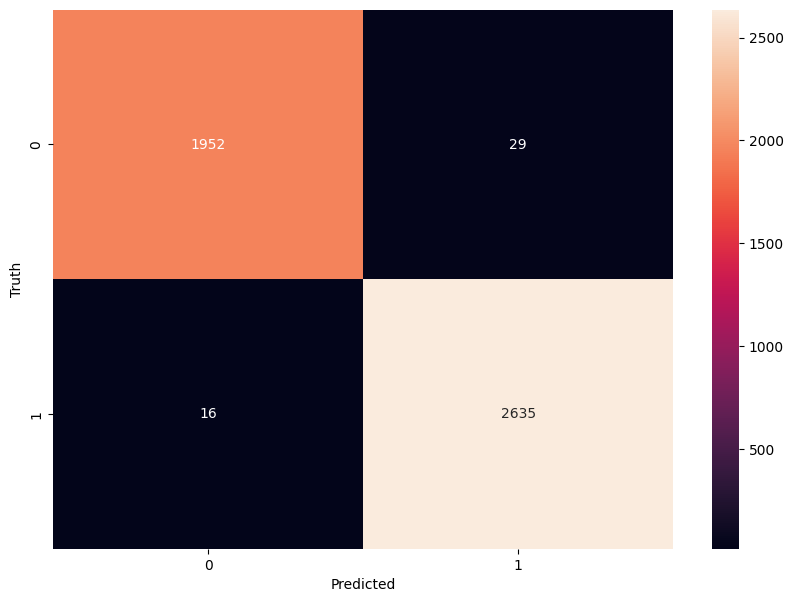

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Расчет confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Визуализация confusion matrix с использованием seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


In [16]:
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(model.last_channel, 2)
model.load_state_dict(torch.load('model_mobileNet.pth', map_location='cpu'))
model.eval()


with torch.no_grad():
    images, labels = data[0]
    images = images.to('cpu').float().unsqueeze(0)
    start = time.time()
    outputs = model(images)
    end = time.time()

print(f'INFERENCE_TIME: {(end-start)}')

INFERENCE_TIME: 0.5993990898132324


MIdas

In [19]:
class CustomModel3(nn.Module):
    def __init__(self):
        super(CustomModel3, self).__init__()
        midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
        self.transform = midas_transforms.small_transform

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dense = nn.Linear(128*8*8, 512, bias=False)
        self.bn3 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(512+512, 2)

    def forward(self, x, midas):
        batch_size = x.size(0)
        x2_list = []
        for i in range(batch_size):
            img = x[i]
            img_transformed = self.transform(img.permute(1, 2, 0).numpy())
            img_transformed = midas(img_transformed)
            img_transformed = img_transformed.view(img_transformed.size(0), -1)
            x2_list.append(img_transformed)
        x2 = torch.stack(x2_list)

        # First input
        x1 = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x1 = self.pool2(F.relu(self.bn2(self.conv2(x1))))
        x1 = x1.view(x.size(0), -1)
        x1 = self.dropout(self.bn3(self.dense(x1)))
        x = self.fc(x1)

        return x


In [22]:
model = CustomModel3()
model.to('cpu')


midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small").to('cpu')

criterion = nn.CrossEntropyLoss().to('cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Using cache found in /home/ivan/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/ivan/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /home/ivan/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


In [24]:
# Функция обучения
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    for images, labels in tqdm(dataloader):
        images = images.float()
        labels = labels.long()
        optimizer.zero_grad()
        outputs = model(images, midas)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


# Функция валидации
def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.float()
            labels = labels.long()
            outputs = model(images, midas)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            # Сохраняем метки и прогнозы для вычисления F1-оценки
            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    val_loss /= len(dataloader.dataset)
    val_accuracy = 100. * correct / len(dataloader.dataset)

    # Вычисляем F1-оценку
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    return val_loss, val_accuracy, f1

# Обучение модели
for epoch in range(2):  # 10 эпох для примера
    train(model, train_loader, criterion, optimizer, device)
    torch.save(model.state_dict(), f'model_MIDAS.pth')
    val_loss, val_accuracy, f1 = validate(model, val_loader, criterion, device)
    print(f'Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, F1 Score: {f1}')

  0%|          | 0/579 [00:00<?, ?it/s]